In [28]:
import pandas as pd
import numpy as np
from scipy import stats
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.colors
from matplotlib import cm
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1 import make_axes_locatable

from matplotlib.patches import Patch
from matplotlib.patches import Circle
from matplotlib.lines import Line2D

from pymodulon.core import IcaData
from pymodulon import example_data
from pymodulon.io import save_to_json, load_json_model
from pymodulon.example_data import load_ecoli_data
from pymodulon.plotting import *
import pymodulon
from pymodulon.enrichment import *

import upsetplot

# import venn

# Explanation of internal strain IDs

- E. coli K-12 del-fhuA (WT) --> DDB35
- E. coli K-12 del-fhuA del-cra (del-cra) --> SDT178
- E. coli K-12 del-fhuA del-crp (del-crp) --> SDT202
- E. coli K-12 del-fhuA del-fliA (del-fliA) --> SDT201
- E. coli K-12 del-fhuA del-prpR (del-prpR) --> SDT173
- E. coli K-12 del-fhuA del-rpoS (del-rpoS) --> SDT180

# Load datasets

## Load ICA data (PRECISE-1K)

In [24]:
ica_data = load_json_model("../data/ica_data/ecoli_p1k.json")

## Load DEGs

In [7]:
def replace_p_value_zeros(deg_df):
    padj_values = list(deg_df.padj)
    new_padj_values = []
    min_replacement = deg_df[deg_df.padj != 0].padj.min() * 0.1
    
    for val in padj_values:
        if val == 0:
            new_padj_values.append(min_replacement)
        elif val == np.nan:
            new_padj_values.append(np.nan)
        else:
            new_padj_values.append(val)
            
    deg_df.padj = new_padj_values
    
    return deg_df

### Scale-down vs reference DEGs

In [8]:
deg_sd_df_all = pd.read_excel("../data/differential_expression/DESeq_results_SDvsCtrl.xlsx", index_col=0)
deg_sd_df_all = deg_sd_df_all[deg_sd_df_all["strain"] != "HMP3071"]
deg_sd_df_all = replace_p_value_zeros(deg_sd_df_all)

In [9]:
deg_sd_df_all = deg_sd_df_all[["baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","strain"]]
deg_sd_df_all

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,strain
b0001,2455.580864,-0.540897,0.378818,-1.427854,0.153334,0.355697,DDB35
b0002,6158.190277,0.091781,0.114682,0.800312,0.423530,0.656486,DDB35
b0003,2241.506653,0.068550,0.073521,0.932397,0.351131,0.586677,DDB35
b0004,2545.952935,0.301183,0.083940,3.588099,0.000333,0.002769,DDB35
b0005,51.240577,-0.041273,0.156417,-0.263863,0.791886,0.902407,DDB35
...,...,...,...,...,...,...,...
b4399,325.142325,-0.570206,0.151722,-3.758238,0.000171,0.001354,SDT202
b4400,319.854201,-0.270644,0.147757,-1.831680,0.066999,0.181078,SDT202
b4401,6868.784415,-0.291328,0.086454,-3.369764,0.000752,0.004816,SDT202
b4402,27.193889,0.555521,0.431529,1.287332,0.197979,0.398230,SDT202


### Strain vs WT DEGs

In [10]:
deg_strain_df_all = pd.read_excel("../data/differential_expression/DESeq_results_StrainvsWT.xlsx", index_col=0)
deg_strain_df_all = deg_strain_df_all[deg_strain_df_all["strain"] != "HMP3071"]
deg_strain_df_all = replace_p_value_zeros(deg_strain_df_all)

In [11]:
deg_strain_df_all = deg_strain_df_all[["baseMean","log2FoldChange","lfcSE","stat","pvalue","padj","strain"]]
deg_strain_df_all

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,strain
b0001,2773.408561,-0.038958,0.596446,-0.065317,0.947922,0.972728,SDT173
b0002,5302.576372,-0.374380,0.123681,-3.026994,0.002470,0.007597,SDT173
b0003,2152.244800,0.091192,0.060211,1.514528,0.129892,0.234481,SDT173
b0004,2248.712610,0.100294,0.058307,1.720102,0.085414,0.165971,SDT173
b0005,56.869798,0.492729,0.194470,2.533697,0.011287,0.029397,SDT173
...,...,...,...,...,...,...,...
b4399,368.166460,-0.023558,0.112358,-0.209666,0.833928,0.875287,SDT202
b4400,359.009662,-0.214591,0.106362,-2.017549,0.043638,0.078769,SDT202
b4401,7705.324420,-0.198257,0.049138,-4.034715,0.000055,0.000178,SDT202
b4402,19.694140,-0.063932,0.367983,-0.173736,0.862073,0.898914,SDT202


# Create gene name mapping
- Mapping gene names to their Accession IDs
- Resources from StringDB and RegulonDB used

In [12]:
# Load gene_mapping
gene_mapping_from_regulondb = pd.read_excel("../data/RegulonDB/gene_bnumber_tmp.xlsx")
gene_mapping_from_regulondb = gene_mapping_from_regulondb.rename(columns={"GENE_NAME":"REGULATED_NAME", "BNUMBER":"gene_id"})
gene_mapping_from_regulondb = gene_mapping_from_regulondb[["REGULATED_NAME","gene_id"]]

gene_mapping_from_stringdb = pd.read_excel("../data/StringDB/gene_background_from_string.xlsx", sheet_name="gene_mapping")
gene_mapping_from_stringdb = gene_mapping_from_stringdb.rename(columns={"gene_name":"REGULATED_NAME"})

genetic_network = pd.read_excel("../data/RegulonDB/genetic_network.xlsx")

In [13]:
gene_name_list = list(pd.concat([gene_mapping_from_stringdb, gene_mapping_from_regulondb]).drop_duplicates("REGULATED_NAME").REGULATED_NAME)

final_gene_mapping = pd.DataFrame()

REGULATED_NAME_list = []
gene_id_list = []

for gene_name in gene_name_list:
    
    if len(gene_mapping_from_stringdb[gene_mapping_from_stringdb["REGULATED_NAME"] == gene_name].gene_id) == 0:
        string_db_id = "not present"
    elif len(gene_mapping_from_stringdb[gene_mapping_from_stringdb["REGULATED_NAME"] == gene_name].gene_id) == 1:
        string_db_id = gene_mapping_from_stringdb[gene_mapping_from_stringdb["REGULATED_NAME"] == gene_name].gene_id.iloc[0]
        
        if type(string_db_id) == str:
            string_db_id = string_db_id
        else:
            string_db_id = "not present"
        
    else:
        string_db_id = "not present"
        
    
    if len(gene_mapping_from_regulondb[gene_mapping_from_regulondb["REGULATED_NAME"] == gene_name].gene_id) == 0:
        regulon_db_id = "not present"
    elif len(gene_mapping_from_regulondb[gene_mapping_from_regulondb["REGULATED_NAME"] == gene_name].gene_id) == 1:
        regulon_db_id = gene_mapping_from_regulondb[gene_mapping_from_regulondb["REGULATED_NAME"] == gene_name].gene_id.iloc[0]
        
        if type(regulon_db_id) == str:
            regulon_db_id = regulon_db_id
        else:
            regulon_db_id = "not present"
            
    else:
        regulon_db_id = "not present"

        
    if (string_db_id != "not present") & (regulon_db_id != "not present") & (string_db_id != regulon_db_id):
        print ("Problem with gene name "+str(gene_name)+". The gene id given by StringDB is "+str(string_db_id)+" and the gene id given by RegulonDB is "+str(regulon_db_id))
    
    elif (string_db_id == "not present") & (regulon_db_id != "not present"):
        REGULATED_NAME_list.append(gene_name)
        gene_id_list.append(regulon_db_id)
        
    elif (string_db_id != "not present") & (regulon_db_id == "not present"):
        REGULATED_NAME_list.append(gene_name)
        gene_id_list.append(string_db_id)
        
    elif (string_db_id != "not present") & (regulon_db_id != "not present") & (string_db_id == regulon_db_id):
        REGULATED_NAME_list.append(gene_name)
        gene_id_list.append(regulon_db_id)
    
    elif (string_db_id == "not present") & (regulon_db_id == "not present"):
        pass
        
final_gene_mapping["gene_id"] = gene_id_list
final_gene_mapping["REGULATED_NAME"] = REGULATED_NAME_list

final_gene_mapping.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4890 entries, 0 to 4889
Data columns (total 2 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   gene_id         4890 non-null   object
 1   REGULATED_NAME  4890 non-null   object
dtypes: object(2)
memory usage: 76.5+ KB


In [14]:
genetic_network = pd.merge(left=genetic_network, right=final_gene_mapping, how="left")
genetic_network.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10718 entries, 0 to 10717
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   REGULATOR_ID          10718 non-null  object
 1   REGULATOR_NAME        10718 non-null  object
 2   REGULATED_ID          10718 non-null  object
 3   REGULATED_NAME        10718 non-null  object
 4   FUNCTION_INTERACTION  10718 non-null  object
 5   EVIDENCE              6874 non-null   object
 6   REGULATOR_TYPE        10718 non-null  object
 7   REGULATED_TYPE        10718 non-null  object
 8   gene_id               8590 non-null   object
dtypes: object(9)
memory usage: 837.3+ KB


In [15]:
genetic_network = genetic_network.dropna(subset=["gene_id"])
genetic_network.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8590 entries, 15 to 10716
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   REGULATOR_ID          8590 non-null   object
 1   REGULATOR_NAME        8590 non-null   object
 2   REGULATED_ID          8590 non-null   object
 3   REGULATED_NAME        8590 non-null   object
 4   FUNCTION_INTERACTION  8590 non-null   object
 5   EVIDENCE              5376 non-null   object
 6   REGULATOR_TYPE        8590 non-null   object
 7   REGULATED_TYPE        8590 non-null   object
 8   gene_id               8590 non-null   object
dtypes: object(9)
memory usage: 671.1+ KB


# Plotting and statistical enrichment

In [16]:
strain_dict = {
    "DDB35":{
        "regulator":None,
        "strain_name":"WT"
    },
    "SDT173":{
        "regulator":"PrpR",
        "strain_name":u"\u0394"+" prpR"
    },
    "SDT178":{
        "regulator":"Cra",
        "strain_name":u"\u0394"+" cra"
    },
    "SDT180":{
        "regulator":"Sigma38",
        "strain_name":u"\u0394"+" rpoS"
    },
    "SDT201":{
        "regulator":"Sigma28",
        "strain_name":u"\u0394"+" fliA"
    },
    "SDT202":{
        "regulator":"CRP",
        "strain_name":u"\u0394"+" crp"
    },
    "e_coli":{
        "regulator":None,
        "strain_name":"e_coli"
    }
}

## Function

In [17]:
def plot_volcano_and_calculate_DEG_enrichments(strain_id_list, deg_dataframe, genetic_network_df, highlighted_regulator_list=["none"], deg_fold_change_threshold=2.0, fdr=0.05,strain_dict=strain_dict):
    
    regulator_exclusion_enrichment_df = pd.DataFrame()
    regulator_enrichment_df = pd.DataFrame()
    cog_enrichment_df = pd.DataFrame()
    iM_enrichment_df = pd.DataFrame()
    deg_results_df = pd.DataFrame()
    
    deg_df = deg_dataframe.copy()
    genetic_network = genetic_network_df.copy()
    
    for strain_id in strain_id_list:
        
        strain_name = strain_dict[strain_id]["strain_name"]
        
        # select insignificant genes
        ############################
        ns_df = deg_df[(deg_df["strain"] == strain_id) & ((deg_df["padj"] > fdr) | ((deg_df["log2FoldChange"] > -np.log2(deg_fold_change_threshold)) & (deg_df["log2FoldChange"] < np.log2(deg_fold_change_threshold))))]
        
        # select up genes
        #################
        up_df = deg_df[(deg_df["strain"] == strain_id) & ((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] >= np.log2(deg_fold_change_threshold)))]
        up_df["direction"] = "up"
        
        # select down genes
        ###################
        down_df = deg_df[(deg_df["strain"] == strain_id) & ((deg_df["padj"] <= fdr) & (deg_df["log2FoldChange"] <= -np.log2(deg_fold_change_threshold)))]
        down_df["direction"] = "down"
        
        # Calucalte enrichments
        #######################
        
        
        ### Regulators with exclusion of knocked-out regulator
        ######################################################
        
        knocked_out_regulator = strain_dict[strain_id]["regulator"]
        
        regulator_list = list(genetic_network["REGULATOR_NAME"].unique())
        regulated_genes_exclusion_list = list(genetic_network[(genetic_network["REGULATOR_NAME"] == knocked_out_regulator) & (genetic_network["REGULATED_TYPE"] == "gene")].gene_id)
        

        for reg in regulator_list:

            # here select only the genes regulated by the regulator reg of the current loop iteration, but not co-regulated by the knocked-out regulator

            regulated_genes_list = list(genetic_network[(genetic_network["REGULATOR_NAME"] == reg) & (genetic_network["REGULATED_TYPE"] == "gene")].gene_id)

            all_genes = list(deg_df.index.unique())
            gene_set_down = list(down_df.index)
            gene_set_up = list(up_df.index)
            target_genes_temp = list(set(regulated_genes_list) - set(regulated_genes_exclusion_list))

            target_genes = []

            for gene_id in target_genes_temp:
                if gene_id in all_genes:
                    target_genes.append(gene_id)

            for direction in ["up", "down"]:

                gene_set = vars()["gene_set_" + direction]

                df1 = compute_enrichment(gene_set, target_genes, all_genes)

                df = pd.DataFrame()
                df = pd.concat([df,df1]).T
                df["Regulator"] = reg
                df["Strain_id"] = strain_id
                df["Strain_name"] = strain_name
                df["Direction"] = direction
                df["All_genes"] = len(all_genes)

                regulator_exclusion_enrichment_df = pd.concat([regulator_exclusion_enrichment_df,df])
        
        
        ### Regulators ######################
        #####################################
        
        regulator_list = list(genetic_network["REGULATOR_NAME"].unique())

        for reg in regulator_list:

            regulated_genes_df_for_enrichment = genetic_network[(genetic_network["REGULATOR_NAME"] == reg) & (genetic_network["REGULATED_TYPE"] == "gene")]

            all_genes = list(deg_df.index.unique())
            gene_set_down = list(down_df.index)
            gene_set_up = list(up_df.index)
            target_genes_temp = list(regulated_genes_df_for_enrichment.gene_id)
            
            target_genes = []
            
            for gene_id in target_genes_temp:
                if gene_id in all_genes:
                    target_genes.append(gene_id)

            for direction in ["up", "down"]:

                gene_set = vars()["gene_set_" + direction]

                df1 = compute_enrichment(gene_set, target_genes, all_genes)

                df = pd.DataFrame()
                df = pd.concat([df,df1]).T
                df["Regulator"] = reg
                df["Strain_id"] = strain_id
                df["Strain_name"] = strain_name
                df["Direction"] = direction
                df["All_genes"] = len(all_genes)

                regulator_enrichment_df = pd.concat([regulator_enrichment_df,df])
                
        ### COGs ############################
        #####################################

        cog_list = list(ica_data.gene_table.COG.unique())

        for cog in cog_list:

            all_genes = list(ica_data.gene_table.index.unique())
            gene_set_down_temp = list(down_df.index)
            gene_set_down = []
            for gene_id in gene_set_down_temp:
                if gene_id in all_genes:
                    gene_set_down.append(gene_id)

            gene_set_up_temp = list(up_df.index)
            gene_set_up = []
            for gene_id in gene_set_up_temp:
                if gene_id in all_genes:
                    gene_set_up.append(gene_id)

            target_genes = list(ica_data.gene_table[ica_data.gene_table.COG == cog].index)

            for direction in ["up", "down"]:

                gene_set = vars()["gene_set_" + direction]

                df1 = compute_enrichment(gene_set, target_genes, all_genes)

                df = pd.DataFrame()
                df = pd.concat([df,df1]).T
                df["COG"] = cog
                df["Strain_id"] = strain_id
                df["Strain_name"] = strain_name
                df["Direction"] = direction
                df["All_genes"] = len(all_genes)

                cog_enrichment_df = pd.concat([cog_enrichment_df,df])
        
        ### imodulons ############################
        ##########################################

        iM_list = list(ica_data.imodulon_table.index.unique())

        for iM in iM_list:
            
            all_genes = list(ica_data.gene_table.index.unique())
            gene_set_down_temp = list(down_df.index)
            gene_set_down = []
            for gene_id in gene_set_down_temp:
                if gene_id in all_genes:
                    gene_set_down.append(gene_id)

            gene_set_up_temp = list(up_df.index)
            gene_set_up = []
            for gene_id in gene_set_up_temp:
                if gene_id in all_genes:
                    gene_set_up.append(gene_id)

            target_genes = list(ica_data.M_binarized[ica_data.M_binarized[iM] == 1.0].index)
            
            for direction in ["up", "down"]:

                gene_set = vars()["gene_set_" + direction]

                df1 = compute_enrichment(gene_set, target_genes, all_genes)

                df = pd.DataFrame()
                df = pd.concat([df,df1]).T
                df["imodulon"] = iM
                df["Strain_id"] = strain_id
                df["Strain_name"] = strain_name
                df["Direction"] = direction
                df["All_genes"] = len(all_genes)

                iM_enrichment_df = pd.concat([iM_enrichment_df,df])
        
        
        # Highlight genes
        #################
        
        for regulator in highlighted_regulator_list:
            
            regulated_genes_df = genetic_network[(genetic_network["REGULATOR_NAME"] == regulator) & (genetic_network["REGULATED_TYPE"] == "gene")]
            up_df["highlighted_regulator"] = regulator
            down_df["highlighted_regulator"] = regulator
            
            ## highlighted and not highlighted genes
            ########################################

            hl_up_list = []
            not_hl_up_list = []
            
            hl_down_list = []
            not_hl_down_list = []

            for gene in up_df.index:

                if gene in list(regulated_genes_df.gene_id):
                    hl_up_list.append(gene)
                else:
                    not_hl_up_list.append(gene)


            for gene in down_df.index:

                if gene in list(regulated_genes_df.gene_id):
                    hl_down_list.append(gene)
                else:
                    not_hl_down_list.append(gene)

            hl_up_df = up_df.loc[hl_up_list]
            not_hl_up_df = up_df.loc[not_hl_up_list]
            
            hl_down_df = down_df.loc[hl_down_list]
            not_hl_down_df = down_df.loc[not_hl_down_list]
            
            deg_results_df = pd.concat([deg_results_df, pd.concat([hl_up_df, not_hl_up_df, hl_down_df, not_hl_down_df])])
            
            # create figure and axis
            ########################

            fig, ax = plt.subplots()

            # plot data
            ###########

            # not significant
            ax.scatter(ns_df['log2FoldChange'],-np.log10(ns_df['padj']),color='grey',alpha=0.3,label='NS',s=20)
            # up genes
            ax.scatter(not_hl_up_df['log2FoldChange'],-np.log10(not_hl_up_df['padj']),color='red',alpha=0.3,label='NS',s=20)
            ax.scatter(hl_up_df['log2FoldChange'],-np.log10(hl_up_df['padj']),color='red',alpha=1,label='NS',s=20, linewidths=1, edgecolors="k")
            # down genes
            ax.scatter(not_hl_down_df['log2FoldChange'],-np.log10(not_hl_down_df['padj']),color='blue',alpha=0.3,label='NS',s=20)
            ax.scatter(hl_down_df['log2FoldChange'],-np.log10(hl_down_df['padj']),color='blue',alpha=1,label='NS',s=20, linewidths=1, edgecolors="k")

            # customize axis label, titles, ticklabels

            # Support lines
            ###############

            # ax.set_ylim(-5,180)
            # ax.set_xlim(-6.5,6.5)

            ax.set_ylim(ax.get_ylim()[0], ax.get_ylim()[1])
            ax.set_xlim(ax.get_xlim()[0], ax.get_xlim()[1])

            ax.hlines(y=-np.log10(fdr), xmin=ax.get_xlim()[0], xmax=ax.get_xlim()[1],colors='k',linestyles="--",linewidth=1)
            ax.vlines(x=np.log2(deg_fold_change_threshold),  ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],colors='k',linestyles="--",linewidth=1)
            ax.vlines(x=-np.log2(deg_fold_change_threshold), ymin=ax.get_ylim()[0], ymax=ax.get_ylim()[1],colors='k',linestyles="--",linewidth=1)

            # Title
            #######

            ax.set_title("Strain: "+strain_name+"; Highlighted genes under regulation of "+regulator, loc="left")

            # Ax titles
            ###########

            ax.set_xlabel("Log2 Fold Change")
            ax.set_ylabel("-log10(P)")


            # label up and down regulated gene counts
            #########################################

            x1 = 1+(ax.get_xlim()[1]-1)/2
            x2 = -1-(-1 - ax.get_xlim()[0])/2
            y = ax.get_ylim()[1]*0.9

            up_highlight_text = str(len(hl_up_list))
            down_highlight_text = str(len(hl_down_list))

            ax.text(
                x=x1,
                y=y,
                s=str(len(up_df))+" ("+up_highlight_text+")",
                horizontalalignment="center",
                verticalalignment="center"
            )
            ax.text(
                x=x2,
                y=y,
                s=str(len(down_df))+" ("+down_highlight_text+")",
                horizontalalignment="center",
                verticalalignment="center"
            )

            
    regulator_exclusion_enrichment_df.index = range(0,len(regulator_exclusion_enrichment_df))
    regulator_exclusion_enrichment_df["-log10(P)"] = -np.log10(regulator_exclusion_enrichment_df["pvalue"])
    regulator_exclusion_enrichment_df["Fold_enrichment"] = (regulator_exclusion_enrichment_df["TP"]/regulator_exclusion_enrichment_df["gene_set_size"])/(regulator_exclusion_enrichment_df["target_set_size"]/regulator_exclusion_enrichment_df["All_genes"])
    regulator_exclusion_enrichment_df["Log2Fold_enrichment"] = np.log2(regulator_exclusion_enrichment_df["Fold_enrichment"])
    
            
    regulator_enrichment_df.index = range(0,len(regulator_enrichment_df))
    regulator_enrichment_df["-log10(P)"] = -np.log10(regulator_enrichment_df["pvalue"])
    regulator_enrichment_df["Fold_enrichment"] = (regulator_enrichment_df["TP"]/regulator_enrichment_df["gene_set_size"])/(regulator_enrichment_df["target_set_size"]/regulator_enrichment_df["All_genes"])
    regulator_enrichment_df["Log2Fold_enrichment"] = np.log2(regulator_enrichment_df["Fold_enrichment"])


    cog_enrichment_df.index = range(0,len(cog_enrichment_df))
    cog_enrichment_df["-log10(P)"] = -np.log10(cog_enrichment_df["pvalue"])
    cog_enrichment_df["Fold_enrichment"] = (cog_enrichment_df["TP"]/cog_enrichment_df["gene_set_size"])/(cog_enrichment_df["target_set_size"]/cog_enrichment_df["All_genes"])
    cog_enrichment_df["Log2Fold_enrichment"] = np.log2(cog_enrichment_df["Fold_enrichment"])
        
        
    iM_enrichment_df.index = range(0,len(iM_enrichment_df))
    iM_enrichment_df["-log10(P)"] = -np.log10(iM_enrichment_df["pvalue"])
    iM_enrichment_df["Fold_enrichment"] = (iM_enrichment_df["TP"]/iM_enrichment_df["gene_set_size"])/(iM_enrichment_df["target_set_size"]/iM_enrichment_df["All_genes"])
    iM_enrichment_df["Log2Fold_enrichment"] = np.log2(iM_enrichment_df["Fold_enrichment"])
    
    
    return regulator_exclusion_enrichment_df, regulator_enrichment_df, cog_enrichment_df, iM_enrichment_df, deg_results_df

## Scale-down vs control

### Volcano plots and enrichment dataframes

C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_df["direction"] = "up"
C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_df["direction"] = "down"
C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

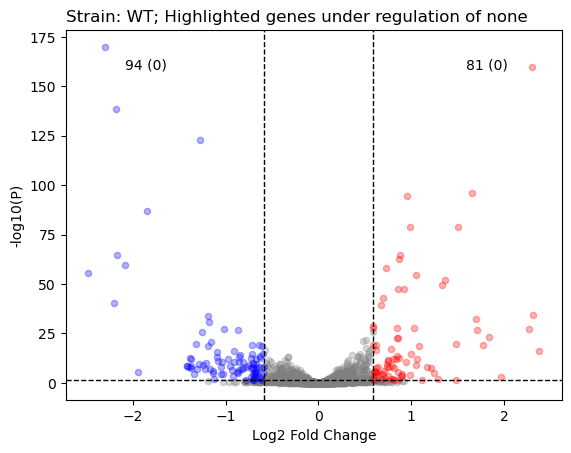

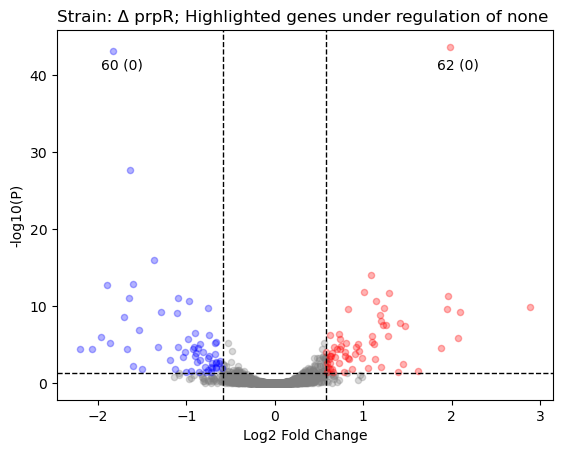

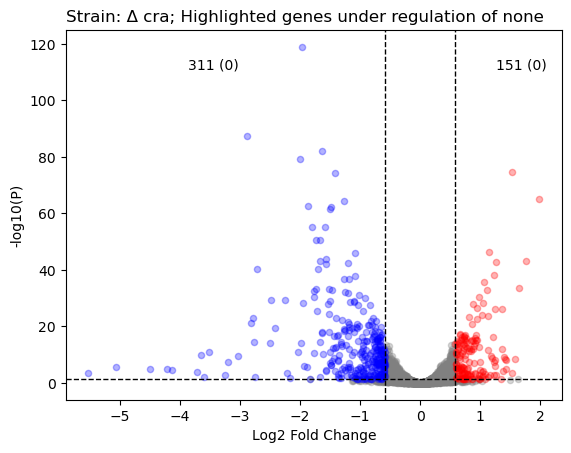

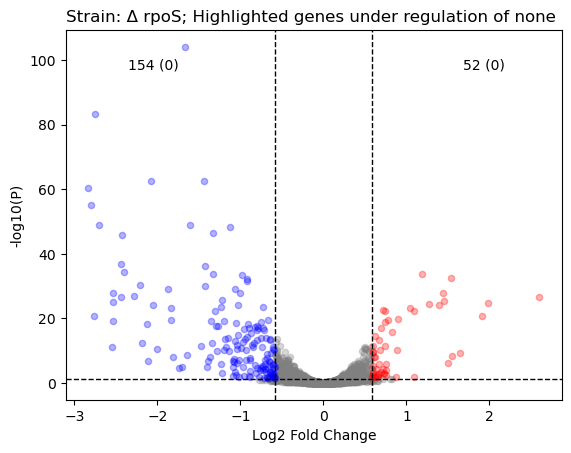

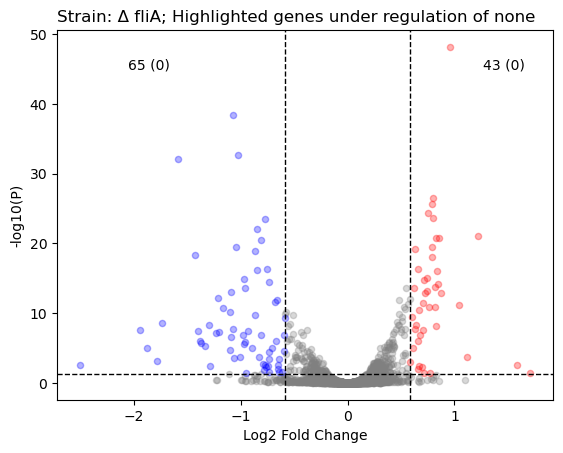

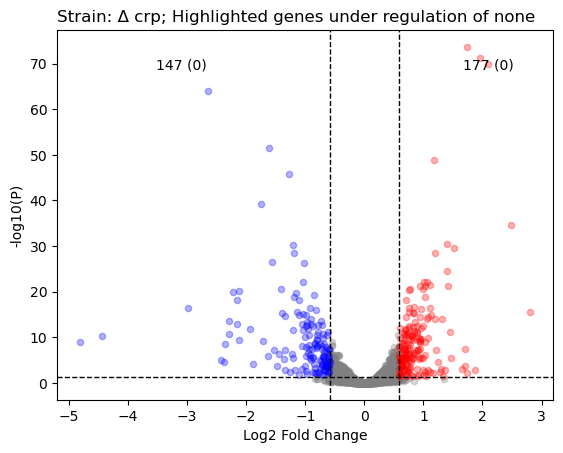

In [25]:
sd_vs_ctrl_regulator_exclusion_enrichment_df, sd_vs_ctrl_regulator_enrichment_df, sd_vs_ctrl_cog_enrichment_df, sd_vs_ctrl_iM_enrichment_df, sd_vs_ctrl_deg_results_df = plot_volcano_and_calculate_DEG_enrichments(
    strain_id_list = ["DDB35","SDT173","SDT178","SDT180","SDT201","SDT202"],
    deg_dataframe = deg_sd_df_all, 
    genetic_network_df = genetic_network, 
    highlighted_regulator_list=["none"], 
    deg_fold_change_threshold=1.5, 
    fdr=0.05,
    strain_dict=strain_dict
)

In [26]:
sd_vs_ctrl_regulator_exclusion_enrichment_df.to_excel("../data/DEG_enrichments/sd_vs_ctrl_regulator_exclusion_enrichment_df.xlsx")
sd_vs_ctrl_regulator_enrichment_df.to_excel("../data/DEG_enrichments/sd_vs_ctrl_regulator_enrichment_df.xlsx")
sd_vs_ctrl_cog_enrichment_df.to_excel("../data/DEG_enrichments/sd_vs_ctrl_cog_enrichment_df.xlsx")
sd_vs_ctrl_iM_enrichment_df.to_excel("../data/DEG_enrichments/sd_vs_ctrl_iM_enrichment_df.xlsx")
sd_vs_ctrl_deg_results_df.to_excel("../data/DEG_enrichments/sd_vs_ctrl_deg_results_df.xlsx")

### UpSet Plot
Useful for counting DEGs

In [27]:
sd_vs_ctrl_deg_results_df.head()

,baseMean,log2FoldChange,lfcSE,stat,pvalue,padj,strain,direction,highlighted_regulator
b0071,4595.598450,0.807893,0.106104,7.614124,2.654855e-14,1.240026e-12,DDB35,up,none
b0072,9091.751225,0.837917,0.108475,7.724503,1.122905e-14,5.491665e-13,DDB35,up,none
b0073,7759.294018,1.031998,0.089800,11.492180,1.444209e-30,1.936638e-28,DDB35,up,none
b0074,9424.491936,0.850867,0.073694,11.545982,7.735334e-31,1.108820e-28,DDB35,up,none
b0273,2779.583574,0.739888,0.108121,6.843164,7.746280e-12,2.683440e-10,DDB35,up,none


In [29]:
deg_df_filtered_down_reg = sd_vs_ctrl_deg_results_df[sd_vs_ctrl_deg_results_df["direction"] == "down"]
deg_df_filtered_down_reg.index.name = "gene_id"
deg_df_filtered_down_reg.reset_index(inplace=True)

deg_df_filtered_up_reg = sd_vs_ctrl_deg_results_df[sd_vs_ctrl_deg_results_df["direction"] == "up"]
deg_df_filtered_up_reg.index.name = "gene_id"
deg_df_filtered_up_reg.reset_index(inplace=True)

In [30]:
down_pivot = deg_df_filtered_down_reg.pivot(index="gene_id", columns="strain", values = "log2FoldChange")
up_pivot = deg_df_filtered_up_reg.pivot(index="gene_id", columns="strain", values = "log2FoldChange")

In [31]:
down_categories = []
down_sets = []

for strain in down_pivot.columns:
    down_categories.append(strain)
    down_sets.append(list(down_pivot[strain].dropna().index))
    
up_categories = []
up_sets = []

for strain in up_pivot.columns:
    up_categories.append(strain)
    up_sets.append(list(up_pivot[strain].dropna().index))

In [32]:
down_contents = dict(zip(down_categories, down_sets))
up_contents = dict(zip(up_categories, up_sets))

down_data = upsetplot.from_contents(down_contents)
up_data = upsetplot.from_contents(up_contents)

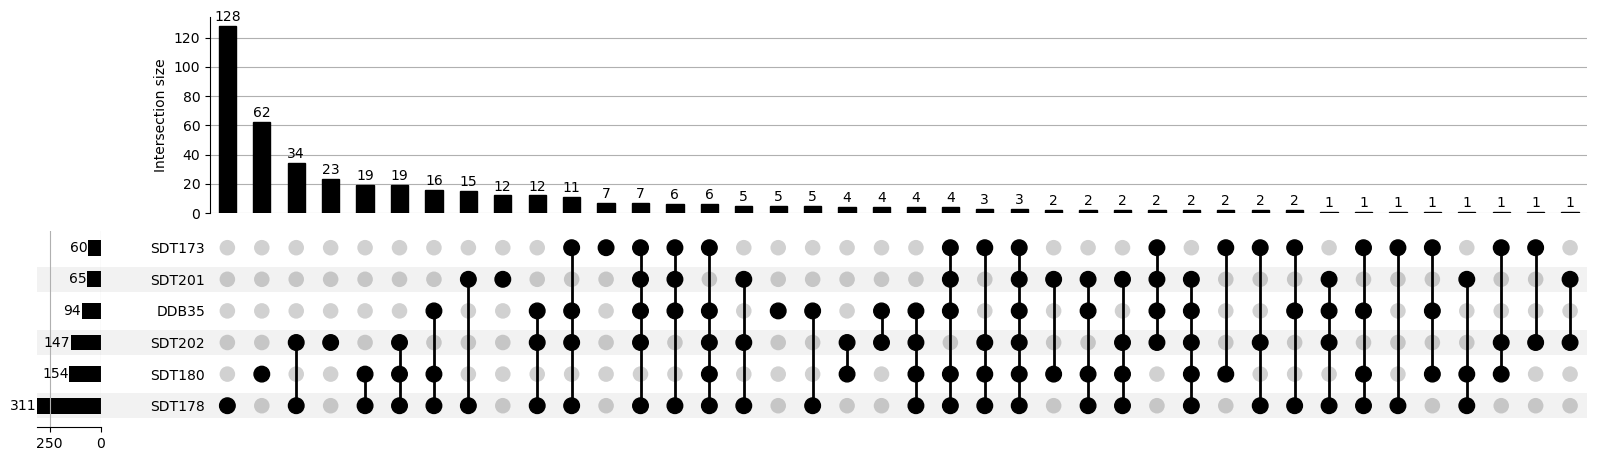

In [33]:
### DOWN ###

upsetplot.UpSet(down_data,sort_by="cardinality",show_counts=True, min_subset_size=0)
# upsetplot.UpSet(down_data,sort_by="cardinality",show_counts=True)

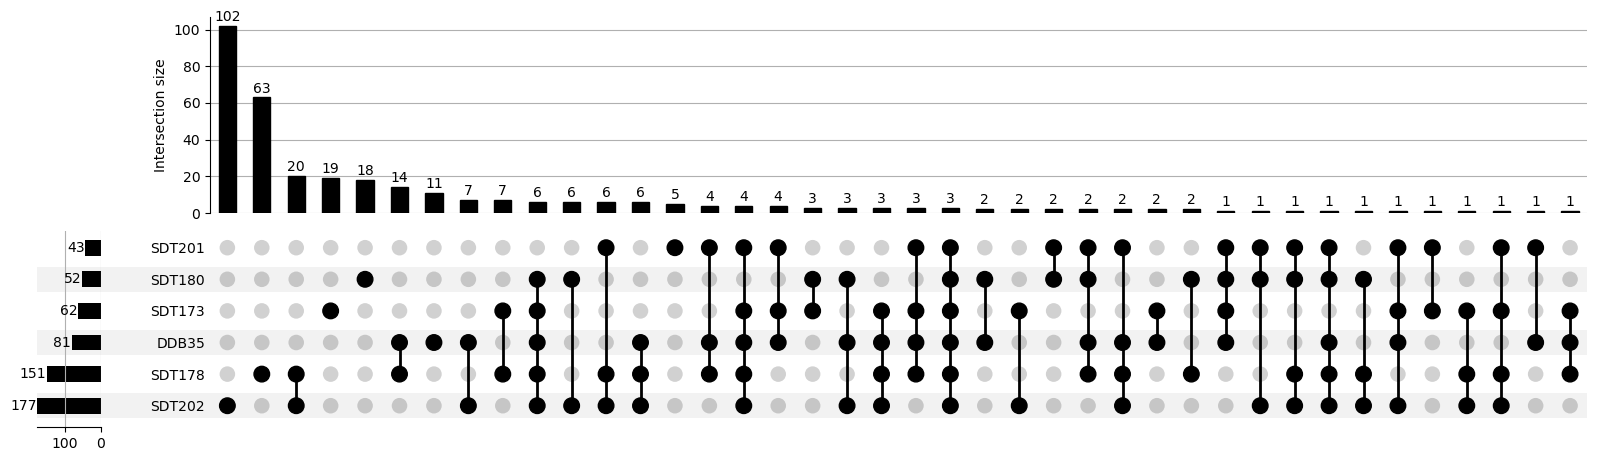

In [34]:
### UP ###

upsetplot.UpSet(up_data,sort_by="cardinality",show_counts=True, min_subset_size=0)
# upsetplot.UpSet(up_data,sort_by="cardinality",show_counts=True)

## Strain vs WT

C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:23: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  up_df["direction"] = "up"
C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:28: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  down_df["direction"] = "down"
C:\Users\jonas\AppData\Local\Temp\ipykernel_20176\2939689939.py:196: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the ca

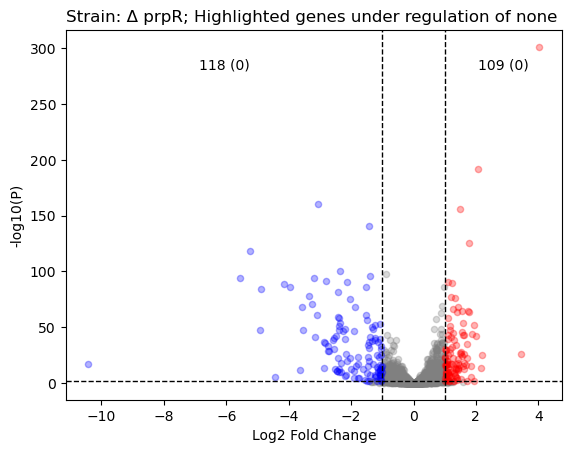

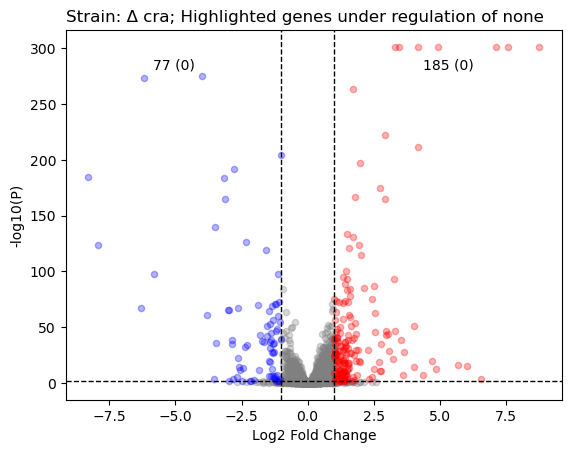

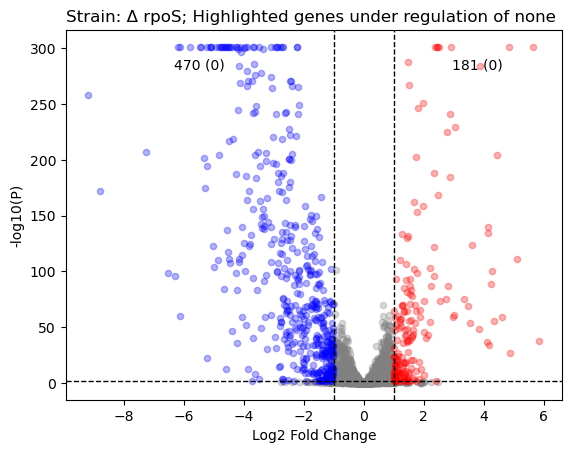

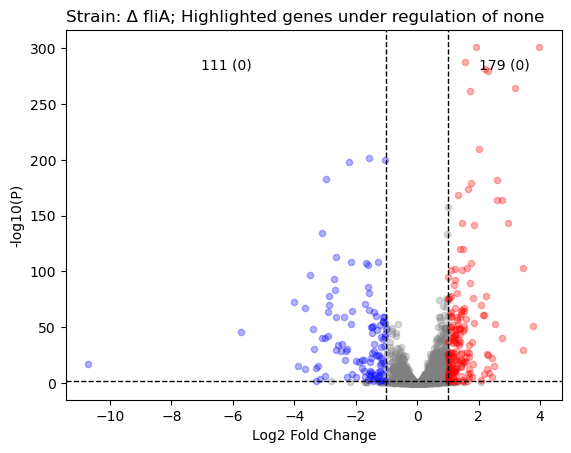

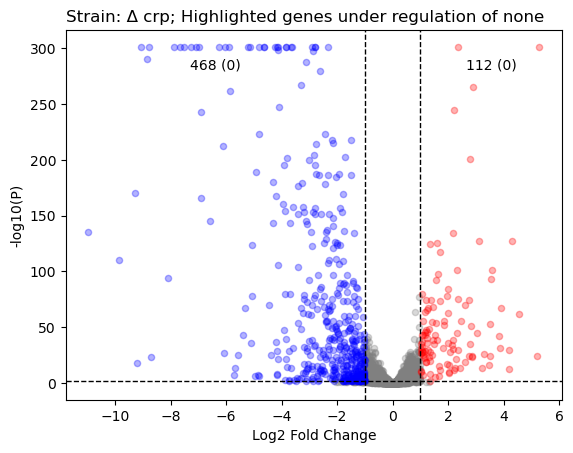

In [35]:
strain_regulator_exclusion_enrichment_df, strain_regulator_enrichment_df, strain_cog_enrichment_df, strain_iM_enrichment_df, strain_deg_results_df = plot_volcano_and_calculate_DEG_enrichments(
    strain_id_list = ["SDT173","SDT178","SDT180","SDT201","SDT202"],
    deg_dataframe = deg_strain_df_all, 
    genetic_network_df = genetic_network, 
    highlighted_regulator_list=["none"], 
    deg_fold_change_threshold=2.0, 
    fdr=0.05,
    strain_dict=strain_dict
)

In [36]:
strain_regulator_exclusion_enrichment_df.to_excel("../data/DEG_enrichments/strain_regulator_exclusion_enrichment_df.xlsx")
strain_regulator_enrichment_df.to_excel("../data/DEG_enrichments/strain_regulator_enrichment_df.xlsx")
strain_cog_enrichment_df.to_excel("../data/DEG_enrichments/strain_cog_enrichment_df.xlsx")
strain_iM_enrichment_df.to_excel("../data/DEG_enrichments/strain_iM_enrichment_df.xlsx")
strain_deg_results_df.to_excel("../data/DEG_enrichments/strain_deg_results_df.xlsx")

### UpSet Plot
Useful for counting DEGs

In [37]:
deg_df_filtered_down_reg = strain_deg_results_df[strain_deg_results_df["direction"] == "down"]
deg_df_filtered_down_reg.index.name = "gene_id"
deg_df_filtered_down_reg.reset_index(inplace=True)

deg_df_filtered_up_reg = strain_deg_results_df[strain_deg_results_df["direction"] == "up"]
deg_df_filtered_up_reg.index.name = "gene_id"
deg_df_filtered_up_reg.reset_index(inplace=True)

In [38]:
down_pivot = deg_df_filtered_down_reg.pivot(index="gene_id", columns="strain", values = "log2FoldChange")
up_pivot = deg_df_filtered_up_reg.pivot(index="gene_id", columns="strain", values = "log2FoldChange")

In [39]:
down_pivot = down_pivot[["SDT178","SDT202", "SDT201", "SDT173", "SDT180"]]
down_pivot.columns = [u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
down_pivot

,Δ cra,Δ crp,Δ fliA,Δ prpR,Δ rpoS
gene_id,,,,,
b0001,NaN,NaN,-1.441389,NaN,NaN
b0019,NaN,NaN,NaN,NaN,-2.581635
b0020,NaN,NaN,NaN,NaN,-1.117154
b0021,-2.458364,-2.603792,-3.223054,-2.393472,-2.230752
b0022,-2.292846,-2.665666,-2.434801,-2.869121,-2.376517
...,...,...,...,...,...
b4742,NaN,-2.116797,NaN,NaN,NaN
b4743,NaN,NaN,NaN,-1.021474,-6.280503
b4750,NaN,NaN,NaN,NaN,-1.266711


In [40]:
up_pivot = up_pivot[["SDT178","SDT202", "SDT201", "SDT173", "SDT180"]]
up_pivot.columns = [u"\u0394"+" cra", u"\u0394"+" crp", u"\u0394"+" fliA", u"\u0394"+" prpR", u"\u0394"+" rpoS"]
up_pivot

,Δ cra,Δ crp,Δ fliA,Δ prpR,Δ rpoS
gene_id,,,,,
b0005,NaN,NaN,NaN,NaN,1.998317
b0016,NaN,NaN,NaN,NaN,2.461481
b0018,NaN,NaN,NaN,1.046460,NaN
b0030,NaN,NaN,1.638982,1.568526,NaN
b0036,NaN,NaN,NaN,NaN,1.044100
...,...,...,...,...,...
b4684,NaN,NaN,1.615942,1.281388,NaN
b4703,NaN,2.198245,NaN,NaN,NaN
b4721,NaN,NaN,NaN,NaN,1.514232


In [41]:
down_categories = []
down_sets = []

for strain in down_pivot.columns:
    down_categories.append(strain)
    down_sets.append(list(down_pivot[strain].dropna().index))
    
up_categories = []
up_sets = []

for strain in up_pivot.columns:
    up_categories.append(strain)
    up_sets.append(list(up_pivot[strain].dropna().index))

In [42]:
down_contents = dict(zip(down_categories, down_sets))
up_contents = dict(zip(up_categories, up_sets))

down_data = upsetplot.from_contents(down_contents)
up_data = upsetplot.from_contents(up_contents)

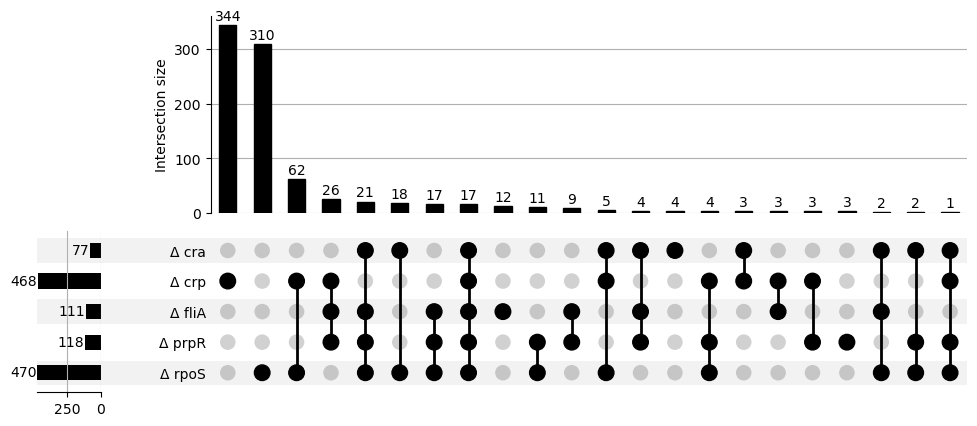

In [43]:
### DOWN ###

upsetplot.UpSet(down_data,sort_by="cardinality",show_counts=True, min_subset_size=1,sort_categories_by='-input')
# upsetplot.UpSet(down_data,sort_by="cardinality",show_counts=True)

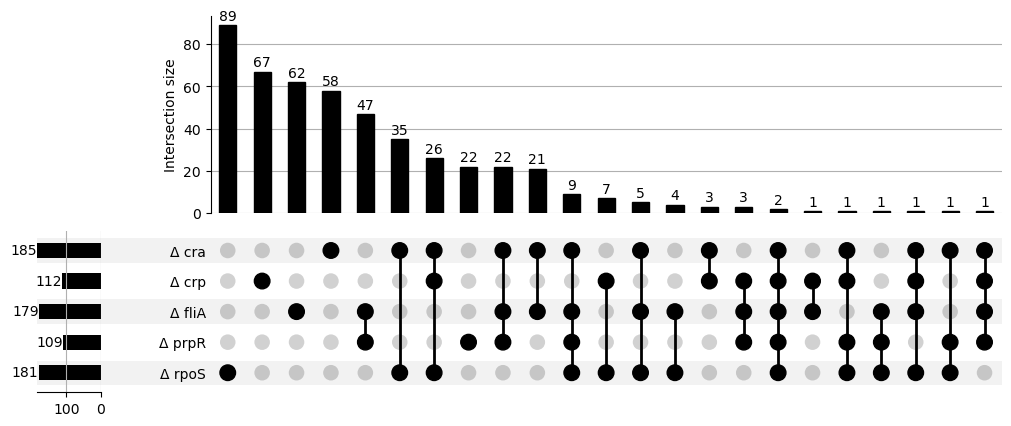

In [44]:
### UP ###

upsetplot.UpSet(up_data,sort_by="cardinality",show_counts=True, min_subset_size=1,sort_categories_by='-input')
# upsetplot.UpSet(up_data,sort_by="cardinality",show_counts=True)